# Data generation by volume

Generate additional RIRs with ```pyroomacoustics``` for a given volume; using monte-carlo techniques, generate a dataset of RIRs distributed over a variety of volumes 

In [2]:
import numpy as np
import librosa as lr
import matplotlib.pyplot as plt
import pyroomacoustics as pra
from numpy import random
from tqdm import tqdm
import os
import pandas as pd
import soundfile as sf

from IPython.display import Audio

ModuleNotFoundError: No module named 'pyroomacoustics'

In [2]:
sr = 44100

#define materials
m = pra.make_materials(
    ceiling="hard_surface",
    floor="carpet_soft_10mm",
    east="gypsum_board",
    west="gypsum_board",
    north="gypsum_board",
    south="gypsum_board",
)


In [20]:
def generate_room_dims(vol, var=.3):
    cube_length = np.power(vol, 1./3)
    side1, side2 = np.random.normal(loc=cube_length, scale=var*cube_length, size=2)
    side3 = vol/(side1*side2)
    return np.array([side1, side2, side3])

for _ in range(10):
    room_dims = generate_room_dims(1000)
    print(room_dims, room_dims[0]*room_dims[1]*room_dims[2])

[ 9.75020223  7.73716611 13.25575461] 1000.0
[15.42464311  7.99096028  8.11308272] 1000.0
[ 6.46238476 11.91032417 12.99222719] 1000.0
[12.9422172   8.99542295  8.58953647] 1000.0
[11.72910349 10.14854578  8.40100739] 1000.0
[ 8.87183359 12.65523167  8.90669362] 1000.0
[13.07264299 12.68367111  6.03103192] 1000.0
[13.36092143  7.21919852 10.36751341] 1000.0
[11.07910606 13.02965931  6.92727167] 1000.0
[ 6.73052821  9.38495988 15.83136752] 1000.0


In [21]:
def generate_rirs(room_dims, n_mics, materials, sr=44100, max_order=10, loc_std=None):
    room_center = room_dims/2
    if loc_std is None:
        loc_std = np.average(room_dims)/3
    
    # Create the room
    room = pra.ShoeBox(
       room_dims, fs=sr, materials=materials, max_order=max_order,
       air_absorption=True, ray_tracing=True
    )
    
    source_loc = generate_in_room(room_center, room_dims, loc_std)
    try:
        room.add_source(source_loc)
    except Exception:
        print("{} in {} ".format(source_loc, room_dims))
    
    mic_locs = []
    for _ in range(n_mics):
        mic_locs.append(generate_in_room(room_center, room_dims, loc_std))
    room.add_microphone(np.array(mic_locs).T)

    room.compute_rir()
    rirs_out = []
    for i in range(n_mics):
        rirs_out.append(room.rir[i][0])
    return rirs_out

def generate_in_room(room_center, room_dims, loc_std, lim=100):
    loc = np.random.multivariate_normal(room_center, np.identity(3)*loc_std)
    count = 0
    while np.any(loc>room_dims) or np.any(loc<0):
        loc = np.random.multivariate_normal(room_center, np.identity(3)*loc_std)
        count += 1
        if count>lim:
            print("Limit {} reached, returning room center")
            loc = room_dims/2
            break
    return loc

    
    

In [22]:
rirs = generate_rirs(np.array([10,10,10]), 10, m)

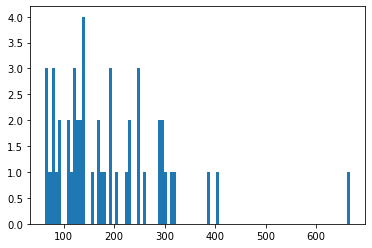

In [23]:
vol_data = np.random.lognormal(mean=np.log(150), sigma=.5, size=50)
_ = plt.hist(vol_data, bins=100)

In [24]:
rirs = []
room_dims = []
for vol in tqdm(vol_data):
    room_dim = generate_room_dims(vol, var=.3)
    room_dims.append(room_dim)
    rir = generate_rirs(room_dim, 1, m, max_order=50)
    rirs.append(rir[0])

100%|███████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


In [8]:
Audio(data=rirs[0], rate=sr)

In [9]:
Audio(data=rirs[25], rate=sr)

In [10]:
Audio(data=rirs[45], rate=sr)

In [11]:

#storing rirs
rir_dir = "/home/cxw/sonos_rirs/pra"
run_name = "0721_pra"

subdir = os.path.join(rir_dir, run_name)
labels = []
files = []
#os.mkdir(subdir)

for i, room_dim in enumerate(tqdm(room_dims)):
    label = run_name + "_room{}".format(i)
    labels.append(label)
    file = os.path.join(subdir, label+'.wav')
    sf.write(file, rirs[i], sr)
    files.append(file)



100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 134.77it/s]


In [12]:
pra_df = pd.DataFrame(files, columns=['file'])
pra_df['vol'] = vol_data
pra_df['room'] = labels
pra_df['dataset'] = run_name

In [115]:
pra_df.to_csv(os.path.join(rir_dir, run_name+'_df.csv'))

In [13]:
#storing rirs
rir_dir = "/home/cxw/sonos_rirs/rirs/pra"
run_name = "080322_pra"

subdir = os.path.join(rir_dir, run_name)

if not os.path.exists(subdir):
    os.makedirs(subdir)
    
labels = []
files = []
#os.mkdir(subdir)

logvol_data = [1.3, 1.4, 1.76, 1.8, 1.82, 1.84,2.05, 2.1, 2.14, 2.19,2.2, 2.23,\
            2.3, 2.31, 2.39, 2.4, 2.43, 2.5, 2.53, 2.55, 2.6, 2.65, 2.7, 2.72,\
            2.75, 2.8, 2.87, 2.9, 3.1, 3.2]

vol_data = [10**logvol for logvol in logvol_data]

room_dims = []
rirs = []
for vol in tqdm(vol_data):
    room_dim = generate_room_dims(vol, var=.3)
    room_dims.append(room_dim)
    rir = generate_rirs(room_dim, 1, m, max_order=50)
    rirs.append(rir[0])
    

100%|███████████████████████████████████████████| 30/30 [00:10<00:00,  2.83it/s]


In [14]:
for i, room_dim in enumerate(tqdm(room_dims)):
    label = run_name + "_room{}".format(i)
    labels.append(label)
    file = os.path.join(subdir, label+'.wav')
    sf.write(file, rirs[i], sr)
    files.append(file)

100%|██████████████████████████████████████████| 30/30 [00:00<00:00, 130.13it/s]


In [15]:
pra_df = pd.DataFrame(files, columns=['file'])
pra_df['vol'] = vol_data
pra_df['room'] = labels
pra_df['dataset'] = run_name

In [16]:
pra_df.to_csv(os.path.join(rir_dir, run_name+'_df.csv'), index=False)

<AxesSubplot:>

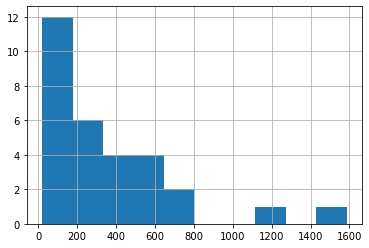

In [17]:
pra_df['vol'].hist()